## Table of contents
1. Introduction
2. Obtaining the data
3. Cleaning the data
4. Exploring the data
5. Modeling
6. Conclusions and recommendations

## 1. Introduciton  
Kickstarter is a founding platform for projects. In this notebook the goal is to help project creaters to descide wheter Kickstarter is a good funding platform for their projects.

Sources:  
https://github.com/L-Lewis/Kickstarter-success-machine-learning/blob/master/Kickstarter-project.ipynb

## 2. Obtaining the data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
#import matplotlib
import matplotlib.pyplot as plt
#import matplotlib as plt
import pylab
#import statsmodels.api as sms
%matplotlib inline
import glob

#train-test split modules
from sklearn.model_selection import train_test_split
RSEED = 50

#scaling
from sklearn.preprocessing import MinMaxScaler #, StandardScaler, OneHotEncoder

#evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report, f1_score

#models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#hyperparameter adjustment
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 

#for XGBoost, the following needs to be installed via terminal:
# brew install libomp
# pip install xgboost

**Combining multiple csv-files into single dataframe**

In [4]:
path = r'data'
all_files = glob.glob(path + '/*.csv')

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

**Looking at the data**

In [5]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     o

## 3. Cleaning the data

**Checking duplicates and keep relevant rows (successful and failed)**

In [6]:
# check for duplicate records
frame['id'].nunique()

182264

In [7]:
frame['name'].nunique()

181680

182256 unique 'id' and 181680 unique 'name' found

In [8]:
# state column should be our final predicted variable--what is in that column?
frame['state'].value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [9]:
# we want to drop any rows that don't have 'successful' or 'failed' state
a = ['successful', 'failed']
frame = frame[frame['state'].isin(a)]

In [10]:
frame['state'].value_counts()

successful    117465
failed         75199
Name: state, dtype: int64

In [11]:
# drop duplicate records
frame = frame.drop_duplicates(subset = 'id', keep = 'first')

In [12]:
pd.set_option('display.max_columns', None)

## 4. Exploring the data

**Feature engineering**

In [13]:
# converting the goal to usd
frame['usd_goal'] = frame['goal'] * frame['static_usd_rate']

In [14]:
# extracting category--we need the first part of what's in the 'slug' key
f = lambda x: x['category'].split('"slug":"')[1].split('/')[0]
frame['category'] = frame.apply(f, axis=1)
f = lambda x: x['category'].split('","position"')[0] # Some categories do not have a sub-category, so do not have a '/' to split with
frame['category'] = frame.apply(f, axis=1)

In [13]:
frame['category'].value_counts()

music           24591
film & video    23889
art             18061
technology      17782
publishing      16997
food            13298
games           10735
fashion          8869
comics           6358
design           5883
photography      5689
crafts           5448
theater          4686
journalism       3684
dance            3009
Name: category, dtype: int64

In [15]:
# converting the date and time columns
cols_to_convert = ['created_at', 'deadline', 'launched_at']
for c in cols_to_convert:
    frame[c] = pd.to_datetime(frame[c], origin='unix', unit='s')
print(f"The dataset contains projects added to Kickstarter between {min(frame.created_at).strftime('%d %B %Y')} and {max(frame.created_at).strftime('%d %B %Y')}.")

The dataset contains projects added to Kickstarter between 22 April 2009 and 04 March 2019.


What to get from the columns with time:

- these columns *may* have interesting information--such as the best month of the year to launch, or the best time of day. We can display this as graphs
- however, this stratification of the data (e.g. by month, or by time of day) may be inappropriate for the model--this can hide certain trends (e.g. looking at time of day alone--it seems like 12-2pm is the best time to launch; but is that also the case for the weekend?)
- we have to do more thinking about how to best include the timing information into the model exactly 
- for now (for our basic model) we will forego looking at the timing information--incorporate it later
- what we *will* do is get the duration of the campaign, into a separate column

**Creating trimmed dataframe**

In [16]:
# create a trimmed dataframe; 
cols_to_drop = ['blurb', 'converted_pledged_amount', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_type']
trimmed_frame = frame.drop(columns=cols_to_drop)

In [17]:
# Campaign length
trimmed_frame['campaign_days'] = frame['deadline'] - frame['launched_at']
trimmed_frame['campaign_days'] = trimmed_frame['campaign_days'].dt.round('d').dt.days
trimmed_frame['launch_month'] = frame['launched_at'].dt.month_name()
trimmed_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168979 entries, 1 to 209221
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   backers_count  168979 non-null  int64         
 1   category       168979 non-null  object        
 2   country        168979 non-null  object        
 3   launched_at    168979 non-null  datetime64[ns]
 4   staff_pick     168979 non-null  bool          
 5   state          168979 non-null  object        
 6   usd_pledged    168979 non-null  float64       
 7   usd_goal       168979 non-null  float64       
 8   campaign_days  168979 non-null  int64         
 9   launch_month   168979 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 13.1+ MB


**EDA**

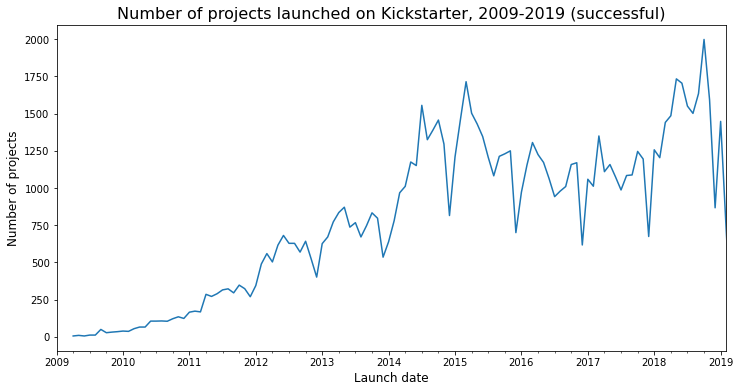

In [18]:
# Plotting the number of projects launched each month
plt.figure(figsize=(12,6))
trimmed_frame[trimmed_frame['state']=='successful'].set_index('launched_at').category.resample('MS').count().plot()
plt.xlim('2009-01-01', '2019-02-28') # Limiting to whole months
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Number of projects', fontsize=12)
plt.title('Number of projects launched on Kickstarter, 2009-2019 (successful)', fontsize=16)
plt.show()

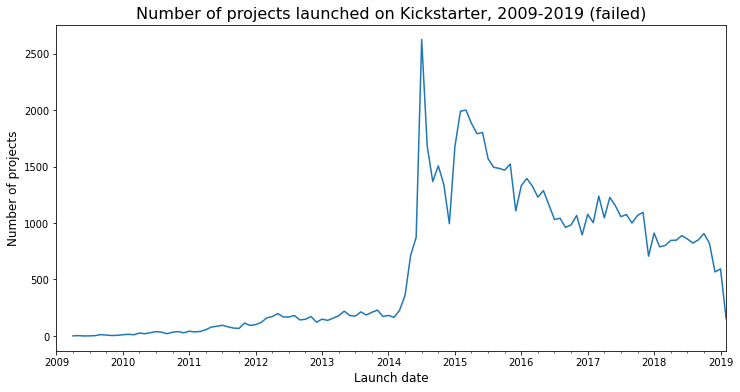

In [19]:
# Plotting the number of projects launched each month
plt.figure(figsize=(12,6))
trimmed_frame[trimmed_frame['state']=='failed'].set_index('launched_at').category.resample('MS').count().plot()
plt.xlim('2009-01-01', '2019-02-28') # Limiting to whole months
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Number of projects', fontsize=12)
plt.title('Number of projects launched on Kickstarter, 2009-2019 (failed)', fontsize=16)
plt.show()

In [21]:
(trimmed_frame[trimmed_frame['state']=='successful'].set_index('launched_at').category.resample('MS').count() / \
(trimmed_frame[trimmed_frame['state']=='successful'].set_index('launched_at').category.resample('MS').count() + \
 trimmed_frame[trimmed_frame['state']=='failed'].set_index('launched_at').category.resample('MS').count()) * 100).plot

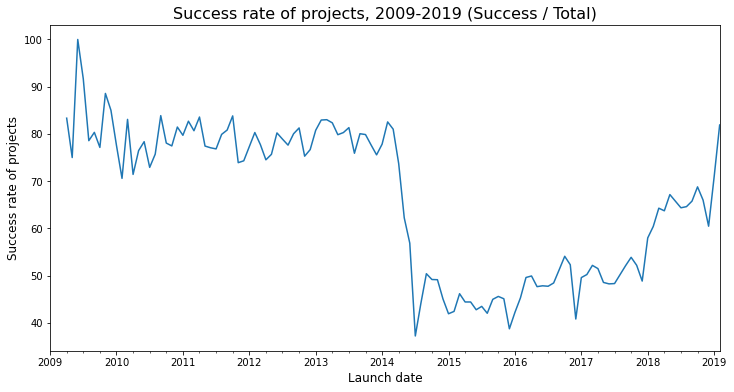

In [20]:
# Plotting the success rate
plt.figure(figsize=(12,6))
(trimmed_frame[trimmed_frame['state']=='successful'].set_index('launched_at').category.resample('MS').count() / \
(trimmed_frame[trimmed_frame['state']=='successful'].set_index('launched_at').category.resample('MS').count() + \
 trimmed_frame[trimmed_frame['state']=='failed'].set_index('launched_at').category.resample('MS').count()) * 100).plot()
plt.xlim('2009-01-01', '2019-02-28') # Limiting to whole months
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Success rate of projects', fontsize=12)
plt.title('Success rate of projects, 2009-2019 (Success / Total)', fontsize=16)
plt.show()

Text(0.5, 0, '')

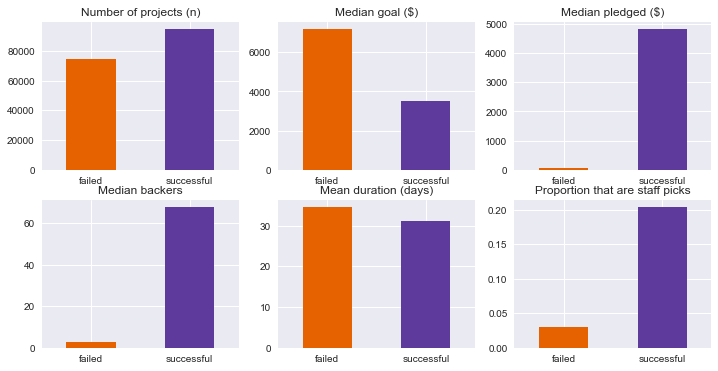

In [22]:
# Plotting the average amount pledged to successful and unsuccesful projects
plt.style.use('seaborn')
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,6))

trimmed_frame['state'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['#E66100','#5D3A9B'], rot=0)
ax1.set_title('Number of projects (n)')
ax1.set_xlabel('')

trimmed_frame.groupby('state').usd_goal.median().plot(kind='bar', ax=ax2, color=['#E66100','#5D3A9B'], rot=0)
ax2.set_title('Median goal ($)')
ax2.set_xlabel('')

trimmed_frame.groupby('state').usd_pledged.median().plot(kind='bar', ax=ax3, color=['#E66100','#5D3A9B'], rot=0)
ax3.set_title('Median pledged ($)')
ax3.set_xlabel('')

trimmed_frame.groupby('state').backers_count.median().plot(kind='bar', ax=ax4, color=['#E66100','#5D3A9B'], rot=0)
ax4.set_title('Median backers')
ax4.set_xlabel('')

trimmed_frame.groupby('state').campaign_days.mean().plot(kind='bar', ax=ax5, color=['#E66100','#5D3A9B'], rot=0)
ax5.set_title('Mean duration (days)')
ax5.set_xlabel('')

# Creating a dataframe grouped by staff_pick with columns for failed and successful
pick_df = pd.get_dummies(trimmed_frame.set_index('staff_pick').state).groupby('staff_pick').sum()
# Normalizes counts by column, and selects the 'True' category (iloc[1])
(pick_df.div(pick_df.sum(axis=0), axis=1)).iloc[1].plot(kind='bar', ax=ax6, color=['#E66100','#5D3A9B'], rot=0) 
ax6.set_title('Proportion that are staff picks')
ax6.set_xlabel('')

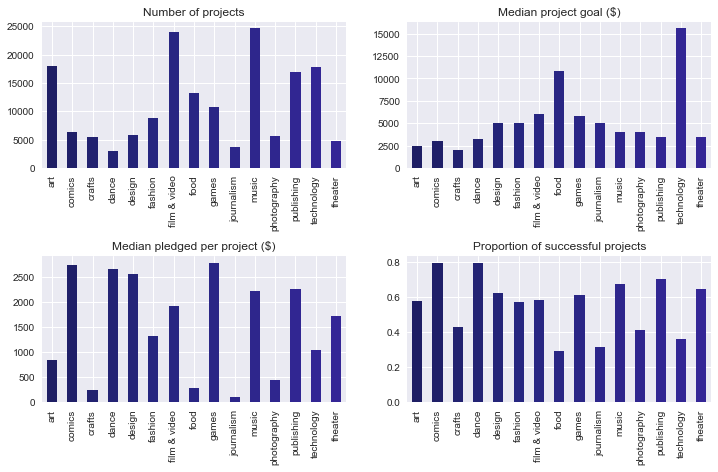

In [23]:
from matplotlib import cm
plt.style.use('seaborn')

# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(trimmed_frame.set_index('category').state).groupby('category').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

color = cm.CMRmap(np.linspace(0.1,0.8,df.category.nunique())) # Setting a colormap

trimmed_frame.groupby('category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

trimmed_frame.groupby('category').usd_goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

trimmed_frame.groupby('category').usd_pledged.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

cat_df.div(cat_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

fig.subplots_adjust(hspace=0.6)
plt.show()

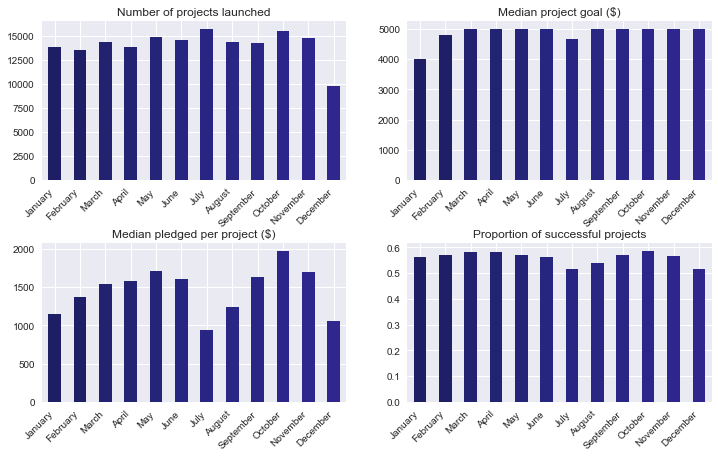

In [24]:
# Creating a dataframe grouped by the month in which they were launched, with columns for failed and successful
month_df = pd.get_dummies(trimmed_frame.set_index('launch_month').state).groupby('launch_month').sum()
import time
import itertools
import calendar
# Plotting
months = list(calendar.month_name)[1:]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

#color = cm.CMRmap(np.linspace(0.1,0.8,trimmed_frame.launch_month.nunique()))

trimmed_frame.groupby('launch_month').launch_month.count().reindex(months).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

trimmed_frame.groupby('launch_month').usd_goal.median().reindex(months).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

trimmed_frame.groupby('launch_month').usd_pledged.median().reindex(months).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

month_df.div(month_df.sum(axis=1), axis=0).successful.reindex(months).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.4)
plt.show()

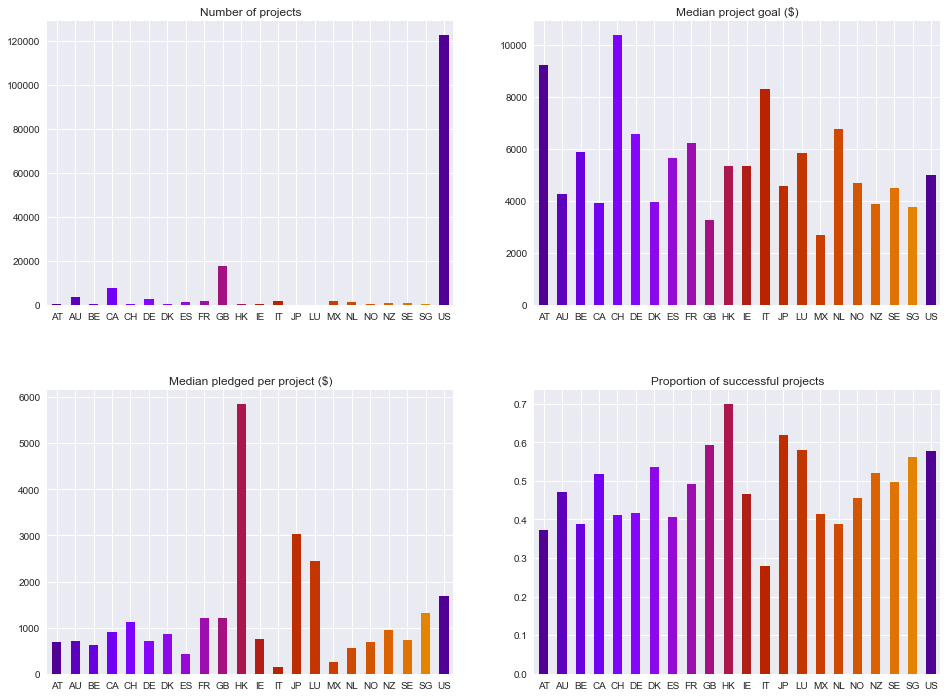

In [25]:
# Creating a dataframe grouped by country with columns for failed and successful
country_df = pd.get_dummies(trimmed_frame.set_index('country').state).groupby('country').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))

color = cm.gnuplot(np.linspace(0.1,0.8,df.country.nunique()))

trimmed_frame.groupby('country').country.count().plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

trimmed_frame.groupby('country').usd_goal.median().plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

trimmed_frame.groupby('country').usd_pledged.median().plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

country_df.div(country_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color, rot=0)
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

## 5. Modeling

The data was examined to check for completeness and to decide which features to include in the model:

In [26]:
trimmed_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168979 entries, 1 to 209221
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   backers_count  168979 non-null  int64         
 1   category       168979 non-null  object        
 2   country        168979 non-null  object        
 3   launched_at    168979 non-null  datetime64[ns]
 4   staff_pick     168979 non-null  bool          
 5   state          168979 non-null  object        
 6   usd_pledged    168979 non-null  float64       
 7   usd_goal       168979 non-null  float64       
 8   campaign_days  168979 non-null  int64         
 9   launch_month   168979 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 13.1+ MB


- There are no null values in the data
- The predicted variable is state--we will need to check if it is balanced or not
- The following features are related to the project campaign, rather than being inherent properties at the start of the project:
    - backers_count
    - usd_pledged

    As this information isn't known when the project creator is starting the campaign, it's not very useful for foretelling whether the project is likely to be a success. Therefore, these features were not included in the model
    
- Numerical features, to be transformed and normalised:
    - usd_goal
    - campaign_days

- Categorical features, to be transformed into dummies:
    - category
    - country
    - staff_pick
    - launch_month  
  
- The 'launched_at' column was only used to derive the 'campaign_days' and the 'launch_month' columns and was therefore dropped

Dropping of irrelevant features:

In [27]:
trimmed_frame = trimmed_frame.drop('backers_count', axis = 1)
trimmed_frame = trimmed_frame.drop('usd_pledged', axis = 1)
trimmed_frame = trimmed_frame.drop('launched_at', axis = 1)

The dataframe was separated into the predicted variable (target; 'state') and the predictor features for the model:

In [28]:
target = trimmed_frame['state']
features = trimmed_frame.drop('state', axis = 1)

The target variable was examined to check whether the outcome classes were balanced or not:

In [29]:
perc_success = round((target.value_counts()[0])/target.count()*100, 2)
perc_failed = round((target.value_counts()[1])/target.count()*100, 2)
print(f"{perc_failed}% of projects failed.")
print(f"{perc_success}% of projects were successful.")

43.91% of projects failed.
56.09% of projects were successful.


The data seems to be fairly well-balanced. This means that little further intervention is needed to be done to further balance the outcome classes. Nevertheless, since there is about 13% difference between the number of projects that succeeded vs failed, a weighted average will be used for the evaluation metrics that will be used to assess model performance.

The target variable is encoded into numerical values (0 for failure, 1 for success):

In [30]:
target = target.apply(lambda x: 1 if x == 'successful' else 0)

### Normalizing the numerical features

Machine learning models assume the input numerical data to be normally distributed. Therefore, the distribution of the two numerical features were checked:

In [31]:
features.describe()

,usd_goal,campaign_days
count,1.689790e+05,168979.000000
mean,4.109688e+04,32.643287
std,1.110957e+06,11.761523
min,1.000000e-02,1.000000
25%,1.500000e+03,30.000000
50%,5.000000e+03,30.000000
75%,1.329770e+04,34.000000
max,1.523501e+08,93.000000


(array([6.0700e+02, 3.2360e+03, 3.9670e+03, 6.1420e+03, 1.0085e+04,
        1.0206e+04, 9.1405e+04, 8.3820e+03, 7.0660e+03, 8.5070e+03,
        2.4650e+03, 1.4700e+03, 1.4834e+04, 1.3200e+02, 4.4000e+01,
        5.3000e+01, 4.2000e+01, 3.1000e+01, 6.2000e+01, 2.4300e+02]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ,
        51.6, 56.2, 60.8, 65.4, 70. , 74.6, 79.2, 83.8, 88.4, 93. ]),
 <BarContainer object of 20 artists>)

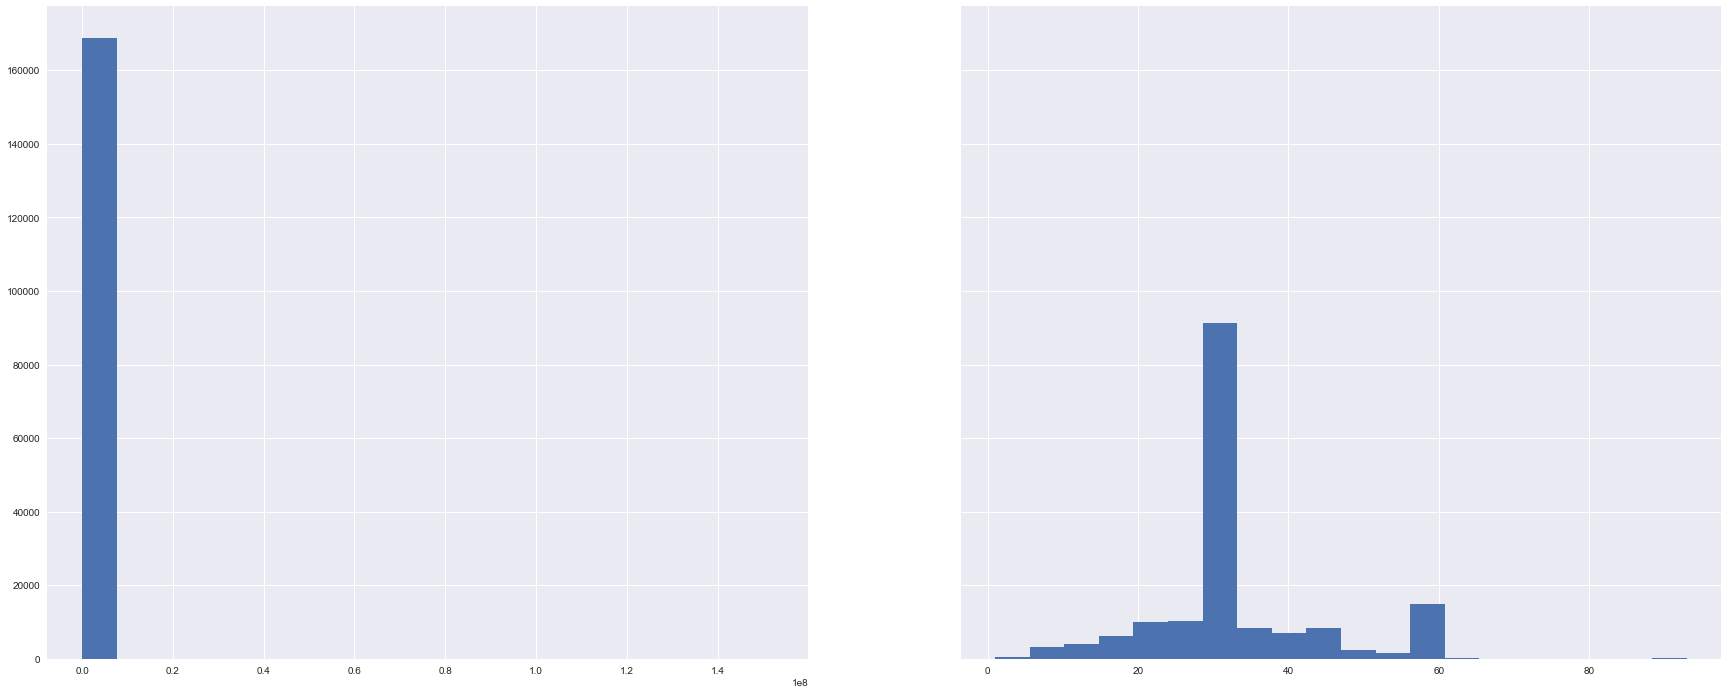

In [32]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize = (30, 12))
axs[0].hist(features['usd_goal'], bins = 20)
axs[1].hist(features['campaign_days'], bins = 20)

- the 'campaign_days' was evenly distributed
- the 'usd_goal' feature was very skewed, as evidenced by the histogram and the discrepancy between the mean and median--the data was thus log-transformed, to achieve normal distribution.

The log transformation of 'usd_goal' resulted in more normally-distributed data:

In [33]:
skewed = ['usd_goal']
features[skewed] = features[skewed].apply(lambda x: np.log(x + 1))

(array([6.0700e+02, 3.2360e+03, 3.9670e+03, 6.1420e+03, 1.0085e+04,
        1.0206e+04, 9.1405e+04, 8.3820e+03, 7.0660e+03, 8.5070e+03,
        2.4650e+03, 1.4700e+03, 1.4834e+04, 1.3200e+02, 4.4000e+01,
        5.3000e+01, 4.2000e+01, 3.1000e+01, 6.2000e+01, 2.4300e+02]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ,
        51.6, 56.2, 60.8, 65.4, 70. , 74.6, 79.2, 83.8, 88.4, 93. ]),
 <BarContainer object of 20 artists>)

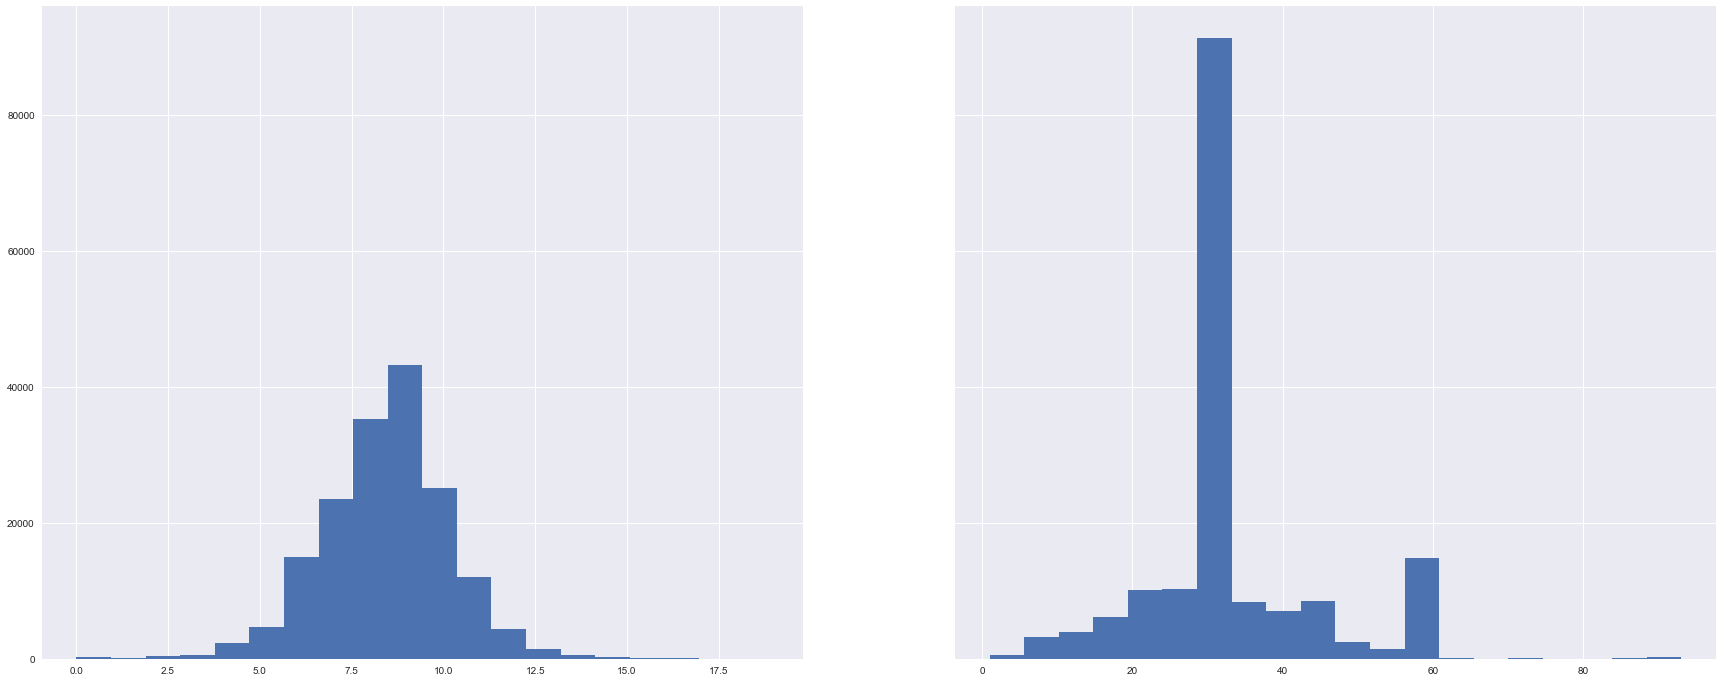

In [34]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize = (30, 12))
#fig.figsize = (30, 12)

axs[0].hist(features['usd_goal'], bins = 20)
axs[1].hist(features['campaign_days'], bins = 20)

### Transforming categorical variables into dummies

The 'category', 'country', 'staff_pick' and 'launch_month' features were all string objects or Boolean and thus needed to be one-hot encoded before they could be implemented in a model:

In [35]:
cat_feats = ['category', 'country', 'staff_pick', 'launch_month']

features = pd.get_dummies(features,columns=cat_feats,drop_first=True)

In [36]:
# Print the number of features after one-hot encoding
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

49 total features after one-hot encoding.


### Test-train split

The data was split into a train and a test set, with 20% of the data being used for the test set. Stratification based on the target variable was used, to ensure the train and test sets had an even distribution of outcome classes.

In [37]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size = 0.2, random_state = RSEED)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 135183 samples.
Testing set has 33796 samples.


### Scaling the data

The numerical features have very different scales, which negatively affects model building. The MinMaxScaler was used to scale these features, to ensure their range falls between 0 and 1:

In [38]:
scaler = MinMaxScaler()
cols_to_scale = ['usd_goal', 'campaign_days']
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

<ipython-input-38-4599360eab47>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
/Users/tobiastnc/neuefische/ds_project_2_ks/.venv/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-38-4599360eab47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

### Naive predictor performance

In order to have a baseline for comparison for our model building, we created a naive performance predictor. This is an untrained 'model' that onlxy predicts the majority outcome class (in our case--that the project is successful). Our supervised learning models are expected to improve on the performance of the naive predictor.

Accuracy and precision were deemed to be the two most important metrics for evaluating model performance: 
- accuracy was picked because it's undesirable to have too many false predictions overall
- f1 score
- precision was important to have more confidence that if your project is predicted to succeed, it would really be the case. Having too many false positives would reduce confidence in the model (false negatives are more acceptable--i.e. a success that the model predicts to be a failure; that's just a happy surprise)

In [39]:
# Calculate accuracy

base_accuracy = ((target.value_counts()[1]) / target.count())

# Calculating precision

base_precision = (target.value_counts()[1]) / ((target.value_counts()[0]) + (target.value_counts()[1]))

# Calculating recall

base_recall = (target.value_counts()[1]) / ((target.value_counts()[1]) + 0)

# Calculating the F-1 score

base_fscore = 2 * (base_precision * base_recall)/(base_precision + base_recall)

print(f"Naive Predictor: Accuracy score: {base_accuracy: .2f}, Precision: {base_precision: .2f}, F1 Score: {base_fscore: .2f}")


Naive Predictor: Accuracy score:  0.56, Precision:  0.56, F1 Score:  0.72


### Model implementation and evaluation

In [40]:
# Instantiate the model; includes random state and probability estimates
logreg_model = LogisticRegression(random_state=RSEED)
rand_forst_model = RandomForestClassifier(random_state=RSEED)
svm_model = SVC(kernel='linear') #put the probability option back in when fine-tuning the model; but for now, leave it out, because it takes ridiculously long probability=True
xgb_model = XGBClassifier(random_state=RSEED)

In [41]:
# measure how long each model takes to run--function

# Define a train and evaluation function
# Note--weighted averages are used for the evaluation metrics, to account for the slight difference in the class sizes
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set and train set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the train set
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute precision on the train set
    results['prec_train'] = precision_score(y_train, predictions_train, average = "weighted")
        
    # Compute precision on test set
    results['prec_test'] = precision_score(y_test,predictions_test, average = "weighted")

    # Compute F-score on the the train set
    results['f_train'] = f1_score(y_train, predictions_train, average = "weighted")
        
    # Compute F-score on the test set
    results['f_test'] = f1_score(y_test, predictions_test, average = "weighted")
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [ ]:
# Runs the fitting and prediction of the models
# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
#for clf in [logreg_model, rand_forst_model, svm_model, xgb_model]: #svm_model time consuming
for clf in [logreg_model, rand_forst_model, xgb_model]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 1352 samples.
LogisticRegression trained on 13518 samples.
LogisticRegression trained on 135183 samples.
RandomForestClassifier trained on 1352 samples.
RandomForestClassifier trained on 13518 samples.


In [ ]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

fig, ax = plt.subplots(2, 3, figsize = (12,10))
bar_width = 0.2
colors = ['#E66100','#5D3A9B','#FFC20A', '#0C7BDC']

for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time', 'acc_train', 'prec_train', 'pred_time', 'acc_test', 'prec_test']):
        for i in np.arange(3):
            # Creative plot code
            ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
            ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
            ax[j//3, j%3].set_xlabel("Training Set Size")
            ax[j//3, j%3].set_xlim((-0.1, 3.0))
# Add unique y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Accuracy Score")
ax[0, 2].set_ylabel("Precision")
ax[1, 0].set_ylabel("Time (in seconds)")
ax[1, 1].set_ylabel("Accuracy Score")
ax[1, 2].set_ylabel("Precision")

# Add titles
ax[0, 0].set_title("Model Training")
ax[0, 1].set_title("Accuracy Score on Training Subset")
ax[0, 2].set_title("Precision on Training Subset")
ax[1, 0].set_title("Model Predicting")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[1, 2].set_title("Precision on Testing Set")

# Add horizontal lines for naive predictors
ax[0, 1].axhline(y = base_accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 1].axhline(y = base_accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[0, 2].axhline(y = base_precision, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 2].axhline(y = base_precision, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

# Set y-limits for score panels
ax[0, 1].set_ylim((0, 1))
ax[0, 2].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[1, 2].set_ylim((0, 1))

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
            loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

# Aesthetics
pl.suptitle("Performance Metrics for Four Supervised Learning Models", fontsize = 16, y = 1.10)
pl.tight_layout()
pl.show()

In [ ]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1: '10%', 2:'100%'}))

In [ ]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

#for i,model in enumerate([logreg_model, rand_forst_model, svm_model, xgb_model]):
for i,model in enumerate([logreg_model, rand_forst_model, xgb_model]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100 # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.1f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax = plt.gca()
    #plt.draw()
    labels = ['Failure', 'Success']
    ax.set_xticklabels(labels, rotation = 45)
    ax.set_yticklabels(labels)
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

SGB Classifier is the best model of the four, in terms of evaluation metrics, and also has an acceptable running time on this dataset--therefore, chosen for further hyperparameter optimisation

**Adjusting of hyperparameters**

https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster (Refer to 'Parameters for Tree Booster')

In [ ]:
# A parameter grid for XGBoost
params = {   }
#params = {
#        'eta': [0.1, 0.5, 1.], #learning rate
#        'min_child_weight': [1, 5, 10], #The larger min_child_weight is, the more conservative the algorithm will be.
#        'gamma': [0.5, 1, 1.5, 2, 5], #Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be
#        'max_depth': [3, 4, 5] #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
#        }

#  Make a precision scoring object
scorer = make_scorer(precision_score) 

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(xgb_model, params, scorer, verbose=0, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_clf = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (xgb_model.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print(best_clf)

**Feature importance**

In [ ]:
#grid_fit=xgb_model.fit(X_train,y_train)
# Get the estimator
#best_clf = grid_fit.best_estimator_ 
fi = pd.DataFrame({'feature': features.columns, 'importance': grid_fit.best_estimator_.feature_importances_}).sort_values('importance', ascending = False)


In [ ]:
fi.head(10)

In [ ]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

for i,model in enumerate([grid_fit]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100 # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.1f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax = plt.gca()
    #plt.draw()
    labels = ['Failure', 'Success']
    ax.set_xticklabels(labels, rotation = 45)
    ax.set_yticklabels(labels)
    plt.title('Confusion matrix for final model (optimised XGB Classifier)');